# Импортирование необходимых библиотек

In [118]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime, os, csv, math
from datetime import timezone, timedelta
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns
from functools import reduce
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

import csv, json, codecs, sys
import urllib.request
import urllib.error
import pandas as pd

import requests
from bs4 import BeautifulSoup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

# Подключение к аккаунту Sentinel Hub

In [3]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [4]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

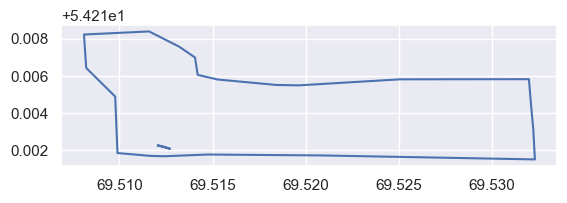

In [5]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [6]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [7]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Составление маски пастбища

In [8]:
aoi_height, aoi_width = pasture_size[-1], pasture_size[0]

In [9]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

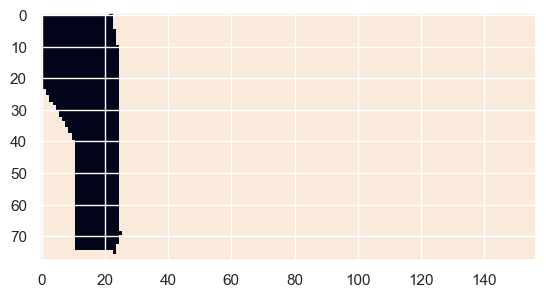

In [10]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

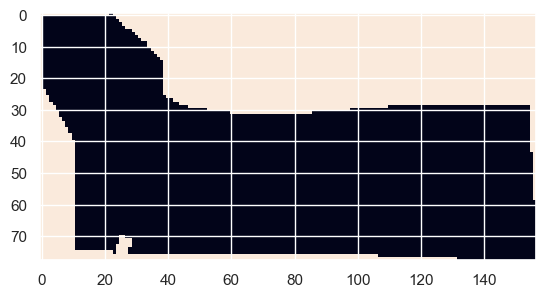

In [11]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [12]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def get_only_zagon(index, zagon):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=masks[zagon-1].reshape(aoi_height, aoi_width))
    return only_pasture

def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))


def show_real_pasture():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    

    
def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False):
    
    fig, ax = plt.subplots(figsize=(12, 12))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    header = input_text
    precision = 4
    # print(f"Макс: {round(float(test_meet.max()),precision)} || Мин: {round(float(test_meet.min()),precision)} || Сред: {round(float(test_meet.mean()),precision)} || Сумм: {round(float(test_meet.sum()),precision)}")
    ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="bwr", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
    plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)

    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), round(zagon.max(),precision), round(zagon.min(),precision)])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Загон", "Сумма", "Cреднаяя", "Медианная", "Макс", "Мин"])
    sum_row = pd.DataFrame({'Загон': ["Пастбище"], 'Сумма': [summary_df['Сумма'].sum()], 'Cреднаяя': [round(float(test_meet.mean()),precision)], 'Медианная': [round(float(ma.median(test_meet)),precision)], 'Макс': [summary_df['Макс'].max()], 'Мин': [summary_df['Мин'].min()]}, index=[len(summary_df.index)])
    summary_df = pd.concat([summary_df, sum_row])
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    display(styled_df)

    if show_hists:
        for i, zagon in enumerate(test_index_masked_array):
            ep.hist(zagon, colors = colors[i], title=f'{header} || Загон-{i+1} {general_info}', cols=4, alpha=0.5,
            figsize = (10, 6))    
            plt.axvline(test_index_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
            plt.axvline(ma.median(test_index_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
            has_negative_or_zero = test_index_masked_array[i] <= 0
            if not has_negative_or_zero.sum():
                plt.axvline(hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
                plt.axvline(gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
                plt.legend([f"Средняя: {test_index_masked_array[i].mean()}",f"Медианная: {ma.median(test_index_masked_array[i])}",f"Гармоническая: {hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}"], title=f'Сумма: {round(zagon.sum(),precision)}')
            else:
                plt.legend([f"Средняя: {ma.mean(test_index_masked_array[i])}",f"Медианная: {ma.median(test_index_masked_array[i])}"], title=f'Сумма: {round(zagon.sum(),precision)}')
        plt.show()
        
        
def get_all_bands(by_pasture=True):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

# Анализ погодных параметров и каналов

## Координаты пастбища

In [13]:
longitude = pasture_bbox.geometry.centroid.coords.xy[0][0]
latitude = pasture_bbox.geometry.centroid.coords.xy[1][0]

# История погоды по заданному диапазону

In [148]:
def get_main_weather_params_history(seek_date):
    if isinstance(seek_date, list):
        l = []
        for d in seek_date:
            l.append(round_up_to_hour(d))
        date_list_df = pd.DataFrame({'dt_iso': l})
        df = pd.merge(grand_history_weather_df, date_list_df, on='dt_iso', how='right')
        df = df.drop(columns=['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'weather_id', 'weather_main', 'weather_description', 'weather_icon'])
    else:
        df = grand_history_weather_df[grand_history_weather_df["dt_iso"] == round_up_to_hour(seek_date)]
        df = df.drop(columns=['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'weather_id', 'weather_main', 'weather_description', 'weather_icon'])
    return df.reset_index(drop=True)

def round_up_to_hour(timestamp):
    if timestamp.minute >= 30:
        # If minutes are above 30, round up to the next hour
        rounded_timestamp = timestamp.replace(
            minute=0, second=0, microsecond=0
        ) + timedelta(hours=1)
    else:
        # Otherwise, round down to the current hour
        rounded_timestamp = timestamp.replace(minute=0, second=0, microsecond=0)

    return rounded_timestamp.strftime('%Y-%m-%d %H:%M:%S %z %Z')

grand_history_weather_df = pd.read_csv('Pasture_Weather_History.csv')

# Дополнительная вспомогательная функция для сбора данных ДЗЗ

In [149]:
def get_date_data(date_chosen, collection, by_pasture=True, median=False):
    global bands_dict

    if collection == "L1C":
        data_collection = DataCollection.SENTINEL2_L1C
    elif collection == "L2A":
        data_collection = DataCollection.SENTINEL2_L2A

    bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
    aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

    evalscript_all_bands = """
        //VERSION=3
        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DN"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in bands_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
    evalscript_all_bands = evalscript_all_bands.format(**settings)


    evalscript_aux_data = """
        //VERSION=3

        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DEGREES"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in aux_data_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
    evalscript_aux_data = evalscript_aux_data.format(**settings)


    time_interval = date_chosen, date_chosen

    search_iterator = catalog.search(
        data_collection,
        bbox=pasture_bbox,
        time=time_interval,
        filter="eo:cloud_cover <= 100",
        fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
    )

    results = list(search_iterator)

    time_difference = datetime.timedelta(hours=1)
    all_timestamps = search_iterator.get_timestamps()
    unique_acquisitions = filter_times(all_timestamps, time_difference)

    image_date_cloud = []
    for date in unique_acquisitions:
        for index in range(len(results)):
            if datetime.datetime.strptime(results[index]['properties']['datetime'], "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc) == date:
                image_date_cloud.append((str(date.date()), results[index]['properties']["eo:cloud_cover"]))
    image_date_cloud = dict(image_date_cloud)

    all_bands_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_all_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        all_bands_process_requests.append(request)

    aux_data_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_aux_data,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        aux_data_process_requests.append(request)

    client = SentinelHubDownloadClient(config=config)
    all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
    all_bands_data = client.download(all_bands_download_requests)

    client = SentinelHubDownloadClient(config=config)
    aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
    aux_data = client.download(aux_data_download_requests)

    white_noise_threshold = 255 # Значение [0-255]
    white_noise_count = 12246 # Количество 157*78=[0-12246]

    clear_date_dict = []
    for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

        data = image.astype(np.float64) / image.max()
        data = 255 * data
        image = data.astype(np.uint8)

        mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        comb = mx1&mx2&mx3
        white_image = comb >= white_noise_threshold
        if white_image.sum() <= white_noise_count:
            clear_date_dict.append((str(timestamp.date().isoformat()), i))

    clear_date_dict = dict(clear_date_dict)
    image_date = clear_date_dict[date_chosen]

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    my_index = (BLUE+NIR)/(RED+SWIR3)

    dt_object = datetime.datetime.strptime(date_chosen, "%Y-%m-%d")
    desired_timezone = datetime.timezone.utc
    result_datetime = dt_object.replace(hour=7, minute=0, second=0, tzinfo=desired_timezone)
    alter_weather_param_df = get_main_weather_params_history(result_datetime)

    column_names = list(alter_weather_param_df.columns)
    values_list = alter_weather_param_df.values.flatten().tolist()

    print(f"Успешно получены каналы для даты: {date_chosen} || Облачность: {image_date_cloud[date_chosen]}")
    if median:
        if "B10" in bands_dict:
            return ["time"] + list(bands_dict.keys()) + ["my_index",] + list(aux_data_dict.keys()) + column_names, [date_chosen, ma.median(ULTRA_BLUE), ma.median(BLUE), ma.median(GREEN), ma.median(RED), ma.median(RED_EDGE1), ma.median(RED_EDGE2), ma.median(RED_EDGE3), ma.median(NIR), ma.median(N_NIR), ma.median(WV), ma.median(SWIR_C), ma.median(SWIR2), ma.median(SWIR3), ma.median(my_index), SZA, SAA, VZM, VAM] + values_list
        else:
            return ["time"] + list(bands_dict.keys()) + ["my_index",] + list(aux_data_dict.keys()) + column_names, [date_chosen, ma.median(ULTRA_BLUE), ma.median(BLUE), ma.median(GREEN), ma.median(RED), ma.median(RED_EDGE1), ma.median(RED_EDGE2), ma.median(RED_EDGE3), ma.median(NIR), ma.median(N_NIR), ma.median(WV), ma.median(SWIR2), ma.median(SWIR3), ma.median(my_index), SZA, SAA, VZM, VAM] + values_list
    else:
        if "B10" in bands_dict:
            return ["time"] + list(bands_dict.keys()) + ["my_index",] + list(aux_data_dict.keys()) + column_names, [date_chosen, ma.mean(ULTRA_BLUE), ma.mean(BLUE), ma.mean(GREEN), ma.mean(RED), ma.mean(RED_EDGE1), ma.mean(RED_EDGE2), ma.mean(RED_EDGE3), ma.mean(NIR), ma.mean(N_NIR), ma.mean(WV), ma.mean(SWIR_C), ma.mean(SWIR2), ma.mean(SWIR3), ma.mean(my_index), SZA, SAA, VZM, VAM] + values_list
        else:
            return ["time"] + list(bands_dict.keys()) + ["my_index",] + list(aux_data_dict.keys()) + column_names, [date_chosen, ma.mean(ULTRA_BLUE), ma.mean(BLUE), ma.mean(GREEN), ma.mean(RED), ma.mean(RED_EDGE1), ma.mean(RED_EDGE2), ma.mean(RED_EDGE3), ma.mean(NIR), ma.mean(N_NIR), ma.mean(WV), ma.mean(SWIR2), ma.mean(SWIR3), ma.mean(my_index), SZA, SAA, VZM, VAM] + values_list

# Получение данных ДЗЗ по доступным датам

In [150]:
# dates_to_analyze = pd.read_csv("dates_to_analyze.csv", header=None, names=["time"])
dates_to_analyze = pd.read_csv("dates_to_analyze_original.csv", header=None, names=["time"])

sample_form = []
for date in list(dates_to_analyze["time"]):
    data_lables, data_list = get_date_data(date, "L2A", by_pasture=False, median=True)
    sample_form.append(data_list)    

Успешно получены каналы для даты: 2020-05-05 || Облачность: 0.0
Успешно получены каналы для даты: 2020-05-07 || Облачность: 0.0
Успешно получены каналы для даты: 2020-05-10 || Облачность: 0.0
Успешно получены каналы для даты: 2020-05-12 || Облачность: 0.71
Успешно получены каналы для даты: 2021-08-13 || Облачность: 0.23
Успешно получены каналы для даты: 2021-08-15 || Облачность: 4.61
Успешно получены каналы для даты: 2021-08-18 || Облачность: 55.12
Успешно получены каналы для даты: 2021-08-20 || Облачность: 3.18
Успешно получены каналы для даты: 2021-08-23 || Облачность: 0.59
Успешно получены каналы для даты: 2021-08-25 || Облачность: 0.0
Успешно получены каналы для даты: 2021-05-12 || Облачность: 60.35
Успешно получены каналы для даты: 2021-05-15 || Облачность: 0.4
Успешно получены каналы для даты: 2021-05-17 || Облачность: 7.97
Успешно получены каналы для даты: 2021-05-20 || Облачность: 97.72
Успешно получены каналы для даты: 2021-05-22 || Облачность: 0.0
Успешно получены каналы для 

In [151]:
indices_df = pd.DataFrame(sample_form, columns=data_lables)
# indices_df = indices_df[indices_df != "--"].dropna()
indices_df

,time,B01,B02,B03,B04,B05,B06,B07,B08,B8A,...,grnd_level,humidity,wind_speed,wind_deg,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all
0,2020-05-05,0.147195,0.303488,0.322421,0.379829,0.590240,0.919665,1.000000,1.000000,1.000000,...,NaN,40.0,1.52,308.0,NaN,NaN,NaN,NaN,NaN,2.0
1,2020-05-07,0.342898,0.254687,0.333225,0.413156,0.632657,0.954393,1.000000,1.000000,1.000000,...,NaN,25.0,1.25,212.0,NaN,NaN,NaN,NaN,NaN,23.0
2,2020-05-10,0.122585,0.309099,0.315435,0.362087,0.562065,0.954352,1.000000,1.000000,1.000000,...,NaN,17.0,6.85,128.0,NaN,NaN,NaN,NaN,NaN,71.0
3,2020-05-12,0.330097,0.250954,0.344071,0.432795,0.692270,1.000000,1.000000,1.000000,1.000000,...,NaN,26.0,1.63,123.0,NaN,NaN,NaN,NaN,NaN,41.0
4,2021-08-13,0.188702,0.185171,0.163697,0.256068,0.430723,0.834024,0.951513,1.000000,1.000000,...,NaN,59.0,4.75,15.0,NaN,NaN,NaN,NaN,NaN,94.0
5,2021-08-15,0.277689,0.169231,0.225144,0.293724,0.497225,0.891972,1.000000,1.000000,1.000000,...,NaN,41.0,2.69,251.0,NaN,NaN,NaN,NaN,NaN,1.0
6,2021-08-18,0.158354,0.133538,0.161765,0.259173,0.441098,0.827655,0.950452,0.973210,1.000000,...,NaN,50.0,3.05,330.0,NaN,NaN,NaN,NaN,NaN,84.0
7,2021-08-20,0.285714,0.164297,0.200449,0.329837,0.511472,0.865621,0.985987,1.000000,1.000000,...,NaN,47.0,2.09,344.0,NaN,NaN,NaN,NaN,NaN,2.0
8,2021-08-23,0.202320,0.166611,0.223374,0.335353,0.514190,0.829123,0.960677,0.965436,1.000000,...,NaN,42.0,3.05,139.0,NaN,NaN,NaN,NaN,NaN,0.0
9,2021-08-25,0.284211,0.195296,0.264478,0.371395,0.570117,0.889674,1.000000,1.000000,1.000000,...,NaN,45.0,3.15,74.0,NaN,NaN,NaN,NaN,NaN,0.0


# Подготовка таблиц

In [152]:
indices_df['RelativeZenith'] = indices_df['sunZenithAngles'] + indices_df['viewZenithMean']
indices_df['RelativeAzimuth'] = indices_df['sunAzimuthAngles'] - indices_df['viewAzimuthMean']
indices_df

,time,B01,B02,B03,B04,B05,B06,B07,B08,B8A,...,wind_speed,wind_deg,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,RelativeZenith,RelativeAzimuth
0,2020-05-05,0.147195,0.303488,0.322421,0.379829,0.590240,0.919665,1.000000,1.000000,1.000000,...,1.52,308.0,NaN,NaN,NaN,NaN,NaN,2.0,43.594173,-106.209198
1,2020-05-07,0.342898,0.254687,0.333225,0.413156,0.632657,0.954393,1.000000,1.000000,1.000000,...,1.25,212.0,NaN,NaN,NaN,NaN,NaN,23.0,46.152645,46.785606
2,2020-05-10,0.122585,0.309099,0.315435,0.362087,0.562065,0.954352,1.000000,1.000000,1.000000,...,6.85,128.0,NaN,NaN,NaN,NaN,NaN,71.0,42.214912,-104.988922
3,2020-05-12,0.330097,0.250954,0.344071,0.432795,0.692270,1.000000,1.000000,1.000000,1.000000,...,1.63,123.0,NaN,NaN,NaN,NaN,NaN,41.0,44.741905,47.128395
4,2021-08-13,0.188702,0.185171,0.163697,0.256068,0.430723,0.834024,0.951513,1.000000,1.000000,...,4.75,15.0,NaN,NaN,NaN,NaN,NaN,94.0,45.730537,-107.595413
5,2021-08-15,0.277689,0.169231,0.225144,0.293724,0.497225,0.891972,1.000000,1.000000,1.000000,...,2.69,251.0,NaN,NaN,NaN,NaN,NaN,1.0,49.389900,45.492783
6,2021-08-18,0.158354,0.133538,0.161765,0.259173,0.441098,0.827655,0.950452,0.973210,1.000000,...,3.05,330.0,NaN,NaN,NaN,NaN,NaN,84.0,47.198898,-107.981186
7,2021-08-20,0.285714,0.164297,0.200449,0.329837,0.511472,0.865621,0.985987,1.000000,1.000000,...,2.09,344.0,NaN,NaN,NaN,NaN,NaN,2.0,50.943382,45.534386
8,2021-08-23,0.202320,0.166611,0.223374,0.335353,0.514190,0.829123,0.960677,0.965436,1.000000,...,3.05,139.0,NaN,NaN,NaN,NaN,NaN,0.0,48.817127,-105.959808
9,2021-08-25,0.284211,0.195296,0.264478,0.371395,0.570117,0.889674,1.000000,1.000000,1.000000,...,3.15,74.0,NaN,NaN,NaN,NaN,NaN,0.0,52.517773,47.196609


# Анализ всех переменных (корреляция)

In [153]:
indices_df.columns

Index(['time', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A',
       'B09', 'B11', 'B12', 'my_index', 'sunZenithAngles', 'sunAzimuthAngles',
       'viewZenithMean', 'viewAzimuthMean', 'temp', 'visibility', 'dew_point',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'sea_level',
       'grnd_level', 'humidity', 'wind_speed', 'wind_deg', 'wind_gust',
       'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h', 'clouds_all',
       'RelativeZenith', 'RelativeAzimuth'],
      dtype='object')

In [187]:
# column_name = 'sunZenithAngles'
# print(indices_df[column_name].min(), indices_df[column_name].max())
# indices_df[column_name].value_counts()

In [155]:
def filter_df(df, column_name, lower_bound, upper_bound):
    if lower_bound is None:
        return df[df[column_name] <= upper_bound]
    elif upper_bound is None:
        return df[df[column_name] >= lower_bound]
    else:
        return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

In [200]:
first_layer_column_name = 'RelativeAzimuth'
first_layer_lower_bound = 0
first_layer_upper_bound = 50

first_layer_filter_df = filter_df(indices_df, first_layer_column_name, first_layer_lower_bound, first_layer_upper_bound)
first_layer_number_of_sample = len(first_layer_filter_df)
print(first_layer_number_of_sample)
first_layer_filter_df[first_layer_column_name]

19


1     46.785606
3     47.128395
5     45.492783
7     45.534386
9     47.196609
10    46.383675
12    46.836304
14    45.503609
16    43.100204
17    44.663673
19    46.488228
21    48.053406
22    44.689865
24    43.306076
25    46.955772
27    47.509666
29    46.407692
31    46.836792
33    45.513298
Name: RelativeAzimuth, dtype: float32

In [201]:
second_layer_column_name = 'viewZenithMean'
second_layer_lower_bound = 6
second_layer_upper_bound = 8

second_layer_filter_df = filter_df(first_layer_filter_df, second_layer_column_name, second_layer_lower_bound, second_layer_upper_bound)
second_layer_number_of_sample = len(second_layer_filter_df)
print(second_layer_number_of_sample)
second_layer_filter_df[second_layer_column_name]

19


1     7.889847
3     7.776812
5     7.817902
7     7.842184
9     7.816176
10    7.833189
12    7.828422
14    7.814284
16    7.819535
17    7.784990
19    7.899986
21    7.738314
22    7.778702
24    7.801260
25    7.814101
27    7.806525
29    7.812721
31    7.799683
33    7.780539
Name: viewZenithMean, dtype: float32

In [202]:
third_layer_column_name = 'sunZenithAngles'
third_layer_lower_bound = 30
third_layer_upper_bound = 36

third_layer_filter_df = filter_df(second_layer_filter_df, third_layer_column_name, third_layer_lower_bound, third_layer_upper_bound)
third_layer_number_of_sample = len(third_layer_filter_df)
print(third_layer_number_of_sample)
third_layer_filter_df[third_layer_column_name]

6


12    35.864803
14    34.848904
22    32.796600
24    32.416199
31    35.968998
33    34.935699
Name: sunZenithAngles, dtype: float32

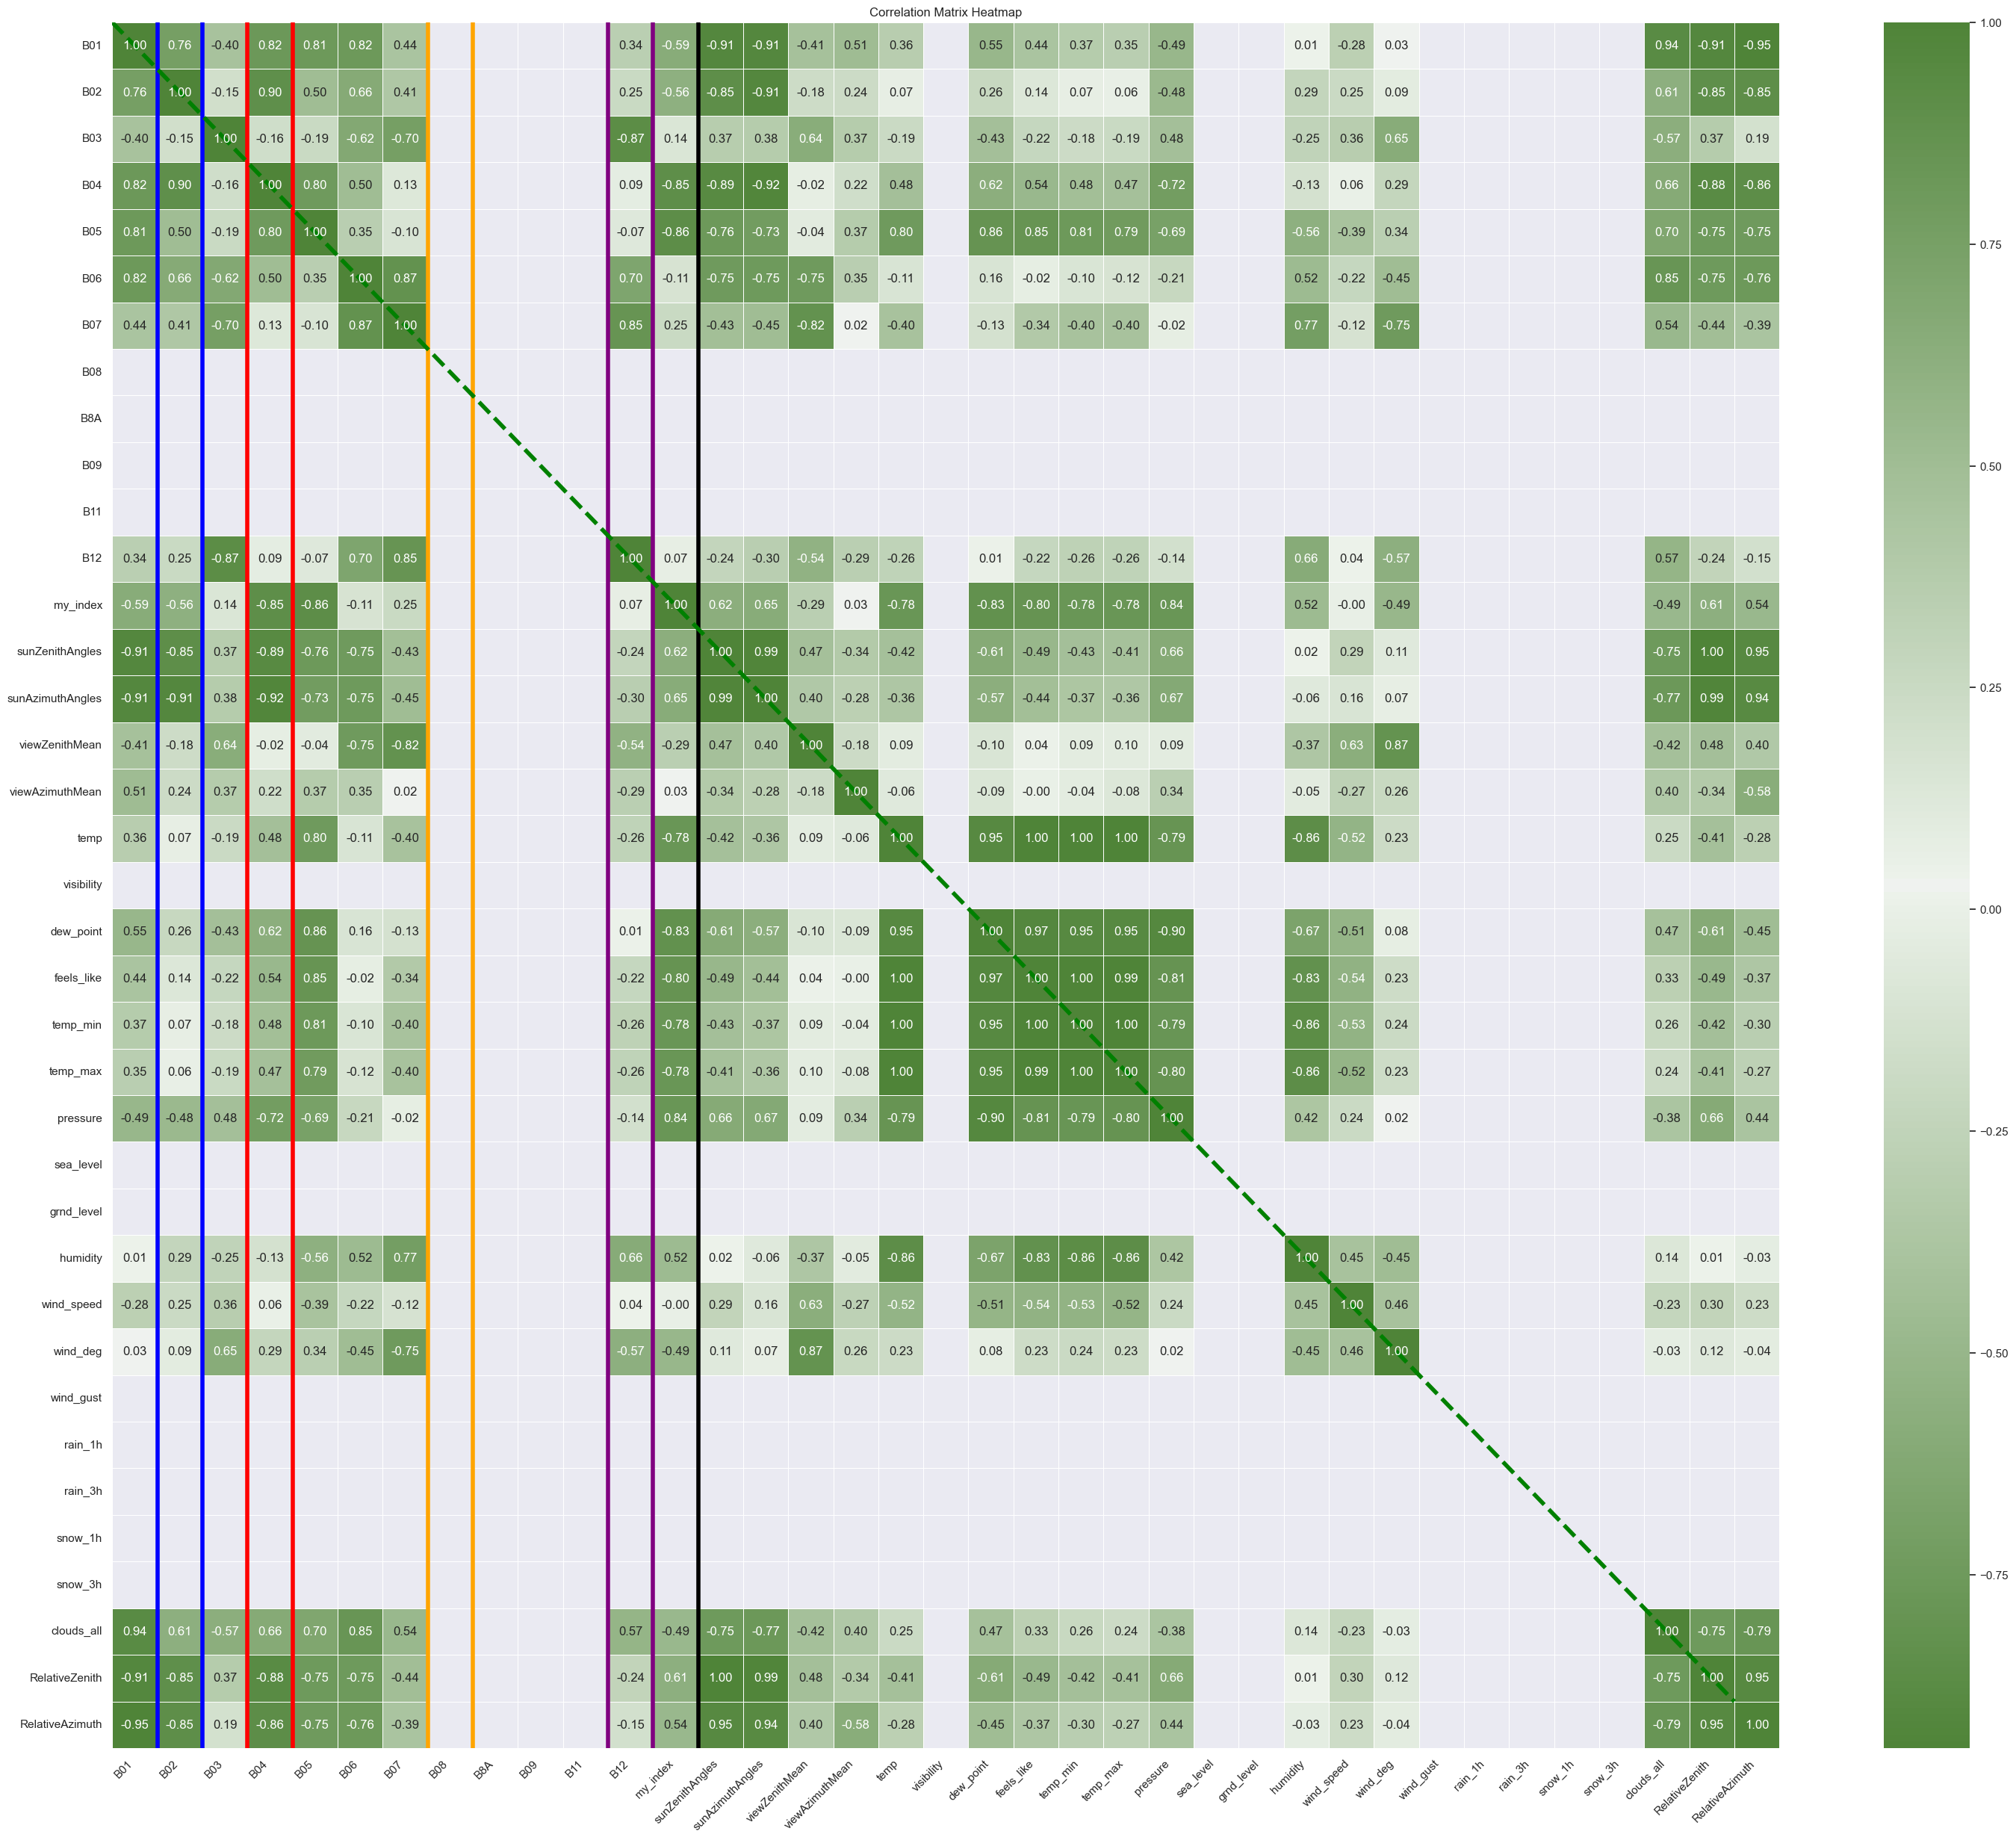

In [203]:
# correlation_matrix = indices_df.drop(columns="time").corr()
# correlation_matrix = first_layer_filter_df.drop(columns="time").corr()
# correlation_matrix = second_layer_filter_df.drop(columns="time").corr()
correlation_matrix = third_layer_filter_df.drop(columns="time").corr()


# Set up the matplotlib figure
plt.figure(figsize=(36, 30))

cmap = sns.diverging_palette(120, 120, as_cmap=True)

# Plot the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f", linewidths=.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

plt.axvline(x=1, color='blue', linestyle='-', linewidth=4)
plt.axvline(x=2, color='blue', linestyle='-', linewidth=4)
plt.axvline(x=3, color='red', linestyle='-', linewidth=4)
plt.axvline(x=4, color='red', linestyle='-', linewidth=4)
plt.axvline(x=7, color='orange', linestyle='-', linewidth=4)
plt.axvline(x=8, color='orange', linestyle='-', linewidth=4)
plt.axvline(x=11, color='purple', linestyle='-', linewidth=4)
plt.axvline(x=12, color='purple', linestyle='-', linewidth=4)
plt.axvline(x=13, color='black', linestyle='-', linewidth=4)

x = np.arange(correlation_matrix.shape[0])
plt.plot(x, x, color='green', linestyle='--', linewidth=4)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.title("Correlation Matrix Heatmap")
# plt.savefig(f'Корреляция {column_name}. Диапазон значении ({lower_bound}-{upper_bound}). Кол.данных {number_of_sample}.png', bbox_inches='tight')
plt.show()

In [199]:
# plt.plot(normalize(third_layer_filter_df["B12"]))
# plt.plot(normalize(third_layer_filter_df["humidity"]))